# IMPORTS

In [ ]:
!pip install pytorch-model-summary

  Using cached pytorch_model_summary-0.1.2-py3-none-any.whl (9.3 kB)


In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline

from pytorch_model_summary import summary

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize, RandomCrop, Normalize

from torch.optim import Adam
from torch.nn import Sequential
from torch.nn import Linear, LeakyReLU, BatchNorm2d, Sigmoid, Tanh, Flatten, BCELoss, Conv2d, ConvTranspose2d, ReLU
from torch.nn.init import normal_, constant_

In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

# LOAD DATA

In [ ]:
image_names = os.listdir("data")

In [ ]:
batch_size = 64

indices = np.random.permutation(len(image_names))


transform = Compose([
                    Resize(80),
                    RandomCrop(64),
                    ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
        
for i in tqdm(range(0, len(image_names), batch_size)):
    ind = indices[i: i + batch_size]
    batch_x = []
    for j in ind:
        img_name = image_names[j]
        img = Image.open("data/" + img_name)
        img = transform(img)
        batch_x.append(img)
    batch_x = torch.stack(batch_x)
    break

  0%|                                                                                           | 0/40 [00:01<?, ?it/s]


In [ ]:
# get shapes of batches
batch_x.shape

torch.Size([64, 3, 64, 64])

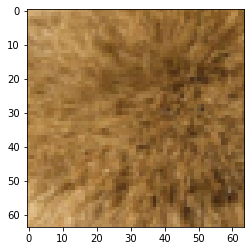

In [ ]:
image = (batch_x[0] + 1) / 2
image = np.transpose(image, (1, 2, 0))
plt.imshow(image)

In [ ]:
batch_x.min(), batch_x.max()

(tensor(-1.), tensor(1.))

# MODEL ARCHITECHTURE

In [ ]:
discriminator = Sequential(
    Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
    LeakyReLU(0.2),
    Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(128),
    LeakyReLU(0.2),
    Conv2d(in_channels=128, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    Sigmoid()
)

In [ ]:
print(summary(discriminator, batch_x[:1]))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 16, 32, 32]             768             768
       LeakyReLU-2     [1, 16, 32, 32]               0               0
          Conv2d-3     [1, 32, 16, 16]           8,192           8,192
     BatchNorm2d-4     [1, 32, 16, 16]              64              64
       LeakyReLU-5     [1, 32, 16, 16]               0               0
          Conv2d-6       [1, 64, 8, 8]          32,768          32,768
     BatchNorm2d-7       [1, 64, 8, 8]             128             128
       LeakyReLU-8       [1, 64, 8, 8]               0               0
          Conv2d-9      [1, 128, 4, 4]         131,072         131,072
    BatchNorm2d-10      [1, 128, 4, 4]             256             256
      LeakyReLU-11      [1, 128, 4, 4]               0               0
         Conv2d-12        [1, 1, 1, 1]           2,048           2,048
     

In [ ]:
# check model on one image
output = discriminator(batch_x[:1]).detach().numpy()

In [ ]:
output

array([[[[0.46490756]]]], dtype=float32)

In [ ]:
generator = Sequential(
    ConvTranspose2d(in_channels=100, out_channels=128, kernel_size=4, stride=1, padding=0, bias=False),
    BatchNorm2d(128),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(64),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(32),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, bias=False),
    BatchNorm2d(16),
    LeakyReLU(0.2),
    ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    Tanh()
)

In [ ]:
print(summary(generator, torch.randn(1, 100, 1, 1)))

RuntimeError: Tensor for argument #1 'input' is on CPU, Tensor for argument #2 'output' is on CPU, but expected them to be on GPU (while checking arguments for slow_conv_transpose2d_out_cuda)

In [ ]:
generator

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2)
  (12): ConvTranspose2d(16, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

In [ ]:
# check model on one image
generator.eval()
output = generator(torch.randn(1, 100, 1, 1)).detach().numpy()

In [ ]:
output.shape

(1, 3, 64, 64)

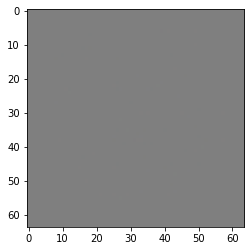

In [ ]:
# print image
image = (output + 1) / 2
image = np.transpose(image.squeeze(), (1, 2, 0))
plt.imshow(image)

In [ ]:
# custom weights initialization 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight.data, 1.0, 0.02)
        constant_(m.bias.data, 0)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
discriminator.apply(weights_init)
generator.apply(weights_init);

# TRAIN

In [ ]:
discriminator = discriminator.to('cuda')
generator = generator.to('cuda')

In [ ]:
# Initialize BCELoss function
criterion = BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# fixed noise for plotting
fixed_noise = torch.randn(1, 100, 1, 1)

# number of epochs
num_epochs = 50

# Setup Adam optimizers for both G and D
optimizerD = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))

  2%|█▋                                                                                 | 1/50 [00:27<22:51, 27.99s/it]

Training loss for epoch 1 is 1.09333 for disciminator and 1.39432 for generator


  4%|███▎                                                                               | 2/50 [01:01<23:47, 29.73s/it]

Training loss for epoch 2 is 1.08213 for disciminator and 1.38892 for generator


  6%|████▉                                                                              | 3/50 [01:31<23:18, 29.77s/it]

Training loss for epoch 3 is 1.11361 for disciminator and 1.47117 for generator


  8%|██████▋                                                                            | 4/50 [01:59<22:29, 29.34s/it]

Training loss for epoch 4 is 1.03375 for disciminator and 1.55401 for generator
Training loss for epoch 5 is 0.98670 for disciminator and 1.79844 for generator

Generated Image


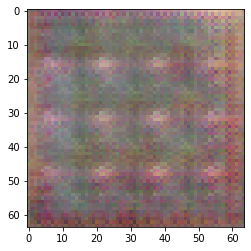

 12%|█████████▉                                                                         | 6/50 [02:57<21:16, 29.01s/it]

Training loss for epoch 6 is 1.02738 for disciminator and 1.73535 for generator


 14%|███████████▌                                                                       | 7/50 [03:25<20:33, 28.68s/it]

Training loss for epoch 7 is 1.05752 for disciminator and 1.64286 for generator


 16%|█████████████▎                                                                     | 8/50 [03:52<19:52, 28.40s/it]

Training loss for epoch 8 is 0.78692 for disciminator and 2.37889 for generator


 18%|██████████████▉                                                                    | 9/50 [04:20<19:17, 28.22s/it]

Training loss for epoch 9 is 0.96701 for disciminator and 2.06107 for generator
Training loss for epoch 10 is 0.96534 for disciminator and 1.98009 for generator

Generated Image


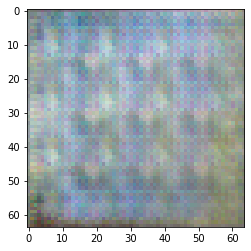

 22%|██████████████████                                                                | 11/50 [05:16<18:16, 28.11s/it]

Training loss for epoch 11 is 0.93174 for disciminator and 2.05629 for generator


 24%|███████████████████▋                                                              | 12/50 [05:44<17:45, 28.03s/it]

Training loss for epoch 12 is 0.90318 for disciminator and 1.91641 for generator


 26%|█████████████████████▎                                                            | 13/50 [06:12<17:16, 28.01s/it]

Training loss for epoch 13 is 0.94577 for disciminator and 2.31092 for generator


 28%|██████████████████████▉                                                           | 14/50 [06:41<16:52, 28.14s/it]

Training loss for epoch 14 is 0.91432 for disciminator and 2.15972 for generator
Training loss for epoch 15 is 0.95077 for disciminator and 1.94150 for generator

Generated Image


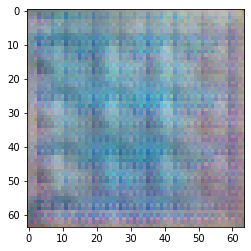

 32%|██████████████████████████▏                                                       | 16/50 [07:41<16:36, 29.31s/it]

Training loss for epoch 16 is 0.92621 for disciminator and 2.02263 for generator


 34%|███████████████████████████▉                                                      | 17/50 [08:10<16:01, 29.13s/it]

Training loss for epoch 17 is 0.87221 for disciminator and 2.10401 for generator


 36%|█████████████████████████████▌                                                    | 18/50 [08:38<15:21, 28.81s/it]

Training loss for epoch 18 is 0.87839 for disciminator and 2.31415 for generator


 38%|███████████████████████████████▏                                                  | 19/50 [09:06<14:47, 28.64s/it]

Training loss for epoch 19 is 0.93662 for disciminator and 1.96521 for generator
Training loss for epoch 20 is 0.99158 for disciminator and 2.00741 for generator

Generated Image


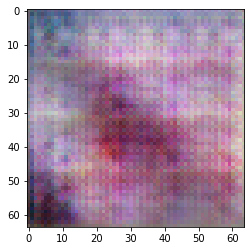

 42%|██████████████████████████████████▍                                               | 21/50 [10:03<13:45, 28.45s/it]

Training loss for epoch 21 is 0.95839 for disciminator and 1.90950 for generator


 44%|████████████████████████████████████                                              | 22/50 [10:31<13:14, 28.38s/it]

Training loss for epoch 22 is 0.92000 for disciminator and 1.95907 for generator


 46%|█████████████████████████████████████▋                                            | 23/50 [10:59<12:44, 28.30s/it]

Training loss for epoch 23 is 0.89197 for disciminator and 2.16261 for generator


 48%|███████████████████████████████████████▎                                          | 24/50 [11:29<12:32, 28.96s/it]

Training loss for epoch 24 is 0.86998 for disciminator and 2.18054 for generator
Training loss for epoch 25 is 0.91123 for disciminator and 2.02985 for generator

Generated Image


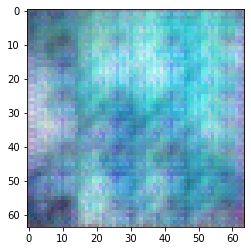

 52%|██████████████████████████████████████████▋                                       | 26/50 [12:30<11:45, 29.39s/it]

Training loss for epoch 26 is 1.04259 for disciminator and 1.87559 for generator


 54%|████████████████████████████████████████████▎                                     | 27/50 [12:58<11:09, 29.12s/it]

Training loss for epoch 27 is 0.99184 for disciminator and 1.92322 for generator


 56%|█████████████████████████████████████████████▉                                    | 28/50 [13:26<10:34, 28.84s/it]

Training loss for epoch 28 is 0.88600 for disciminator and 2.18722 for generator


 58%|███████████████████████████████████████████████▌                                  | 29/50 [13:55<10:03, 28.72s/it]

Training loss for epoch 29 is 0.92556 for disciminator and 2.31444 for generator
Training loss for epoch 30 is 0.78748 for disciminator and 2.21390 for generator

Generated Image


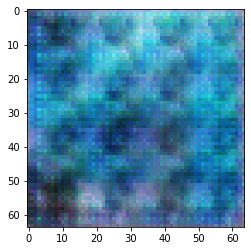

 62%|██████████████████████████████████████████████████▊                               | 31/50 [14:53<09:11, 29.00s/it]

Training loss for epoch 31 is 0.79832 for disciminator and 2.42921 for generator


 64%|████████████████████████████████████████████████████▍                             | 32/50 [15:21<08:38, 28.79s/it]

Training loss for epoch 32 is 0.74233 for disciminator and 2.58643 for generator


 66%|██████████████████████████████████████████████████████                            | 33/50 [15:50<08:07, 28.68s/it]

Training loss for epoch 33 is 0.74206 for disciminator and 2.54676 for generator


 68%|███████████████████████████████████████████████████████▊                          | 34/50 [16:18<07:37, 28.61s/it]

Training loss for epoch 34 is 0.81348 for disciminator and 2.39320 for generator
Training loss for epoch 35 is 0.86742 for disciminator and 2.19891 for generator

Generated Image


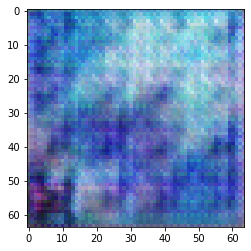

 72%|███████████████████████████████████████████████████████████                       | 36/50 [17:14<06:36, 28.35s/it]

Training loss for epoch 36 is 0.86328 for disciminator and 2.11283 for generator


 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [17:42<06:06, 28.23s/it]

Training loss for epoch 37 is 0.74524 for disciminator and 2.17588 for generator


 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [18:10<05:38, 28.18s/it]

Training loss for epoch 38 is 0.93950 for disciminator and 1.93093 for generator


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [18:39<05:09, 28.15s/it]

Training loss for epoch 39 is 0.92366 for disciminator and 1.90661 for generator
Training loss for epoch 40 is 0.87676 for disciminator and 2.13765 for generator

Generated Image


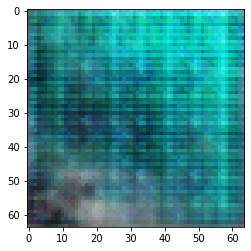

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [19:35<04:13, 28.13s/it]

Training loss for epoch 41 is 0.85571 for disciminator and 2.09888 for generator


 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [20:03<03:44, 28.05s/it]

Training loss for epoch 42 is 0.86606 for disciminator and 1.90986 for generator


 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [20:31<03:16, 28.04s/it]

Training loss for epoch 43 is 0.92009 for disciminator and 2.12075 for generator


 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [20:59<02:48, 28.00s/it]

Training loss for epoch 44 is 0.81345 for disciminator and 2.24886 for generator
Training loss for epoch 45 is 0.83768 for disciminator and 2.16065 for generator

Generated Image


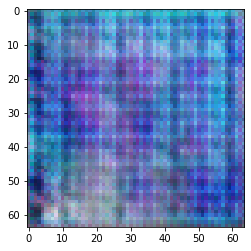

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [21:55<01:52, 28.17s/it]

Training loss for epoch 46 is 0.72054 for disciminator and 2.51378 for generator


 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [22:23<01:24, 28.17s/it]

Training loss for epoch 47 is 0.82732 for disciminator and 2.21732 for generator


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [22:52<00:56, 28.16s/it]

Training loss for epoch 48 is 0.85718 for disciminator and 1.82584 for generator


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [23:20<00:28, 28.17s/it]

Training loss for epoch 49 is 0.59590 for disciminator and 2.34952 for generator
Training loss for epoch 50 is 0.90684 for disciminator and 2.17751 for generator

Generated Image


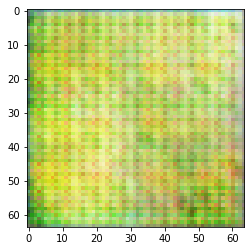

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [23:48<00:00, 28.57s/it]


In [ ]:
# set model to train
discriminator.train()
generator.train()

# train model
for epoch in tqdm(range(num_epochs)):

    # initialize variables
    epochG_loss = epochD_loss = cnt = 0

    batch_size = 64
        
    for i in range(0, len(image_names), batch_size):
        ind = indices[i: i + batch_size]
        batch_x = []
        for j in ind:
            img_name = image_names[j]
            img = Image.open("data/" + img_name)
            img = transform(img)
            batch_x.append(img)
        batch_x = torch.stack(batch_x)
        
        ## train discriminator

        
        # get batch images and targets and transfer them to GPU
        batch_x = batch_x.to("cuda").float()

        batch_size = batch_x.shape[0]

        batch_y = torch.full((batch_size,), real_label, device="cuda").float()

        # clear gradients
        discriminator.zero_grad()

        # pass images to model
        outputs = discriminator(batch_x).view(-1)

        # get loss
        errD_real = criterion(outputs, batch_y)

        # do a backward pass
        errD_real.backward()

        generated_images = generator(torch.randn(batch_size, 100, 1, 1, device="cuda"))

        batch_y = torch.full((batch_size,), fake_label, device="cuda").float()

        # pass images to model
        outputs = discriminator(generated_images.detach()).view(-1)

        # get loss
        errD_fake = criterion(outputs, batch_y)

        # do a backward pass
        errD_fake.backward()

        # update gradients
        optimizerD.step()

        ## train generator

        # clear gradients
        generator.zero_grad()

        batch_y = torch.full((batch_size,), real_label, device="cuda").float()

        outputs = discriminator(generated_images).view(-1)

        # get loss
        errG = criterion(outputs, batch_y)

        # do a backward pass
        errG.backward()

        # add loss
        errD = errD_real + errD_fake

        # update gradients
        optimizerG.step()

        # sum loss and get count
        epochD_loss += errD.item()
        epochG_loss += errG.item()
        cnt += 1

    # take average loss for all batches
    epochD_loss /= cnt
    epochG_loss /= cnt
    
    # print loss
    print("Training loss for epoch {} is {:.5f} for disciminator and {:.5f} for generator".format(epoch + 1, epochD_loss, epochG_loss))

    if (epoch + 1) % 5 == 0:
        print('\nGenerated Image')

        # get prediction
        generator.eval()
        with torch.no_grad():
            output = generator(fixed_noise.to('cuda')).detach().cpu().numpy()

        # plot generated image
        image = (output + 1) / 2
        image = np.transpose(image.squeeze(), (1, 2, 0))
        plt.imshow(image)
        plt.show()

        # revert back to training
        generator.train()

# GENERATING IMAGES

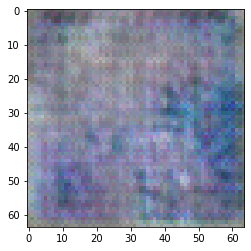

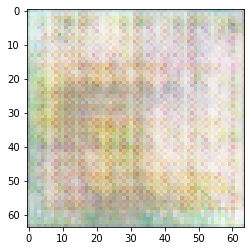

In [ ]:
generator.eval()
generated_images = generator(torch.randn(2, 100, 1, 1).to('cuda')).detach().cpu().numpy()

# print image
for image in generated_images:
    image = (image + 1) / 2
    image = np.transpose(image.squeeze(), (1, 2, 0))
    plt.imshow(image)
    plt.show()

In [ ]:
generated_images.min(), generated_images.mean(), generated_images.max()

(-0.7186336, 0.3129351, 0.97336787)